In [1]:
import os
import yaml

import numpy as np
import pandas as pd

from natsort import natsort_keygen

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import zarr
import dask.array as da
from tifffile import imread

from PIL import Image
from numpy import asarray

from skimage.color import gray2rgb
from skimage.util.dtype import img_as_float

from utils.utility_functions import transposeZarr

plt.rcParams['font.family'] = 'Arial'

In [2]:
# choose square image window size (in pixels) for image patch gallery.
# This is arbitrary and can differ from the cellcutter window size
window_size = 200

In [3]:
# data selection

# segmentation
# clustering, latent_dim = ('Seg', None)

# 9um model
clustering, latent_dim = ('VAE9_VIG7', 412)

# 30um model
# clustering, latent_dim = ('VAE30', 4444)

In [4]:
# read image patch dataframe
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# read SARDANA-097 image contrast settings (defined in CyLinter)
contrast_dir = os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')
contrast_limits = yaml.safe_load(open(contrast_dir))

if latent_dim is not None:
    # read combined training, validation, and test thumbnails
    root = os.path.join(os.getcwd(), f'input/{clustering}')
    combo_dir = os.path.join(root, f'6_latent_space_LD{latent_dim}/combined_zarr')
    X_combo = zarr.open(combo_dir)
    
    # rearrange Zarr dimensions to conform to expected VAE input
    # (i.e. cells, x, y, channels)
    X_combo = transposeZarr(z=X_combo)

# read OME-TIFF, segmentation outlines, and H&E channels
tif_path = os.path.join(os.getcwd(), 'input/CRC-097_image.ome.tif')
seg_path = os.path.join(os.getcwd(), 'input/CRC-097_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), 'input/CRC-097_hema_eosin.ome.tif')

# out dir
out = os.path.join(os.getcwd(), f'output/cluster_context/{clustering}')
if not os.path.exists(out):
    os.makedirs(out)

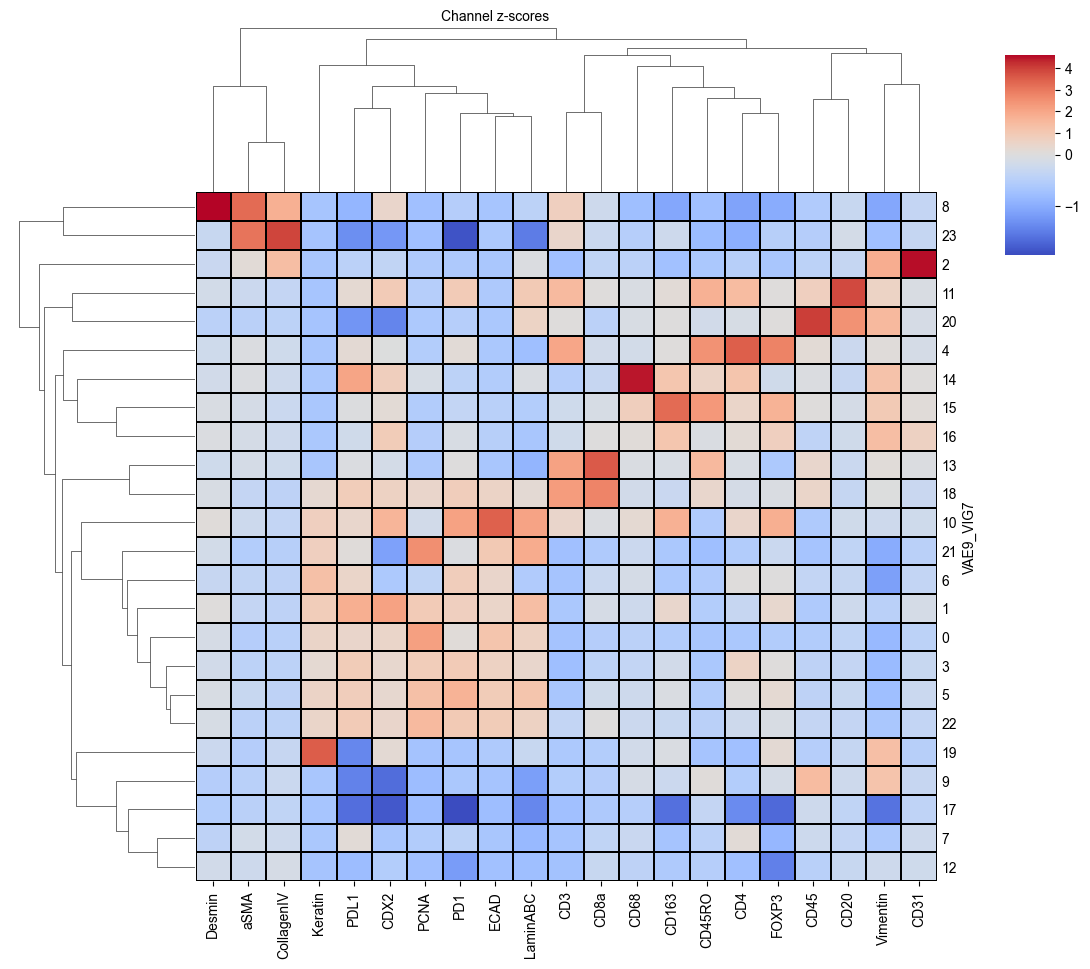

In [5]:
# compute and plot channel z-scores
channels = {
    'anti_CD3': 0, 'anti_CD45RO': 1, 'Keratin_570': 2, 'aSMA_660': 3, 'CD4_488': 4, 'CD45_PE': 5,
    'PD1_647': 6, 'CD20_488': 7, 'CD68_555': 8, 'CD8a_660': 9, 'CD163_488': 10, 'FOXP3_570': 11,
    'PDL1_647': 12, 'Ecad_488': 13, 'Vimentin_555': 14, 'CDX2_647': 15, 'LaminABC_488': 16,
    'Desmin_555': 17, 'CD31_647': 18, 'PCNA_488': 19, 'CollagenIV_647': 20
}

antibody_abbrs = {
    'Hoechst0': 'DNA', 'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': 'aSMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

if latent_dim is not None:
    
    # compute median values of per patch, per channel pixel intensity medians
    medians = da.median(X_combo, axis=(1, 2)).compute()
    clustermap_input = pd.DataFrame(columns=[i for i in channels.keys()], data=medians)
    clustermap_input[clustering] = main[clustering]
    clustermap_input = clustermap_input.groupby(clustering).median()
else:
    # compute mean intensity of cells per cluster
    clustermap_input = main[list(channels.keys()) + ['Seg']].groupby('Seg').mean()

# compute per channel z-scores across clusters
clustermap_input = (clustermap_input-clustermap_input.mean())/clustermap_input.std()

# zero-center colorbar
norm = TwoSlopeNorm(vcenter=0, vmin=clustermap_input.min().min(), vmax=clustermap_input.max().max())

clustermap_object = sns.clustermap(
        clustermap_input, cmap='coolwarm', standard_scale=None, yticklabels=1, xticklabels=1,
        linewidths=0.1, linecolor='k', cbar=True, norm=norm 
    )
clustermap_object.ax_heatmap.set_xticklabels(
    [antibody_abbrs[i.get_text()] for i in clustermap_object.ax_heatmap.get_xticklabels()], rotation=90
)
clustermap_object.ax_heatmap.set_yticklabels(
    [i.get_text() for i in clustermap_object.ax_heatmap.get_yticklabels()], rotation=0
)
clustermap_object.ax_cbar.set_position([1.01, 0.75, 0.05, 0.2])
clustermap_object.fig.suptitle('Channel z-scores', y=0.995, fontsize=10)
clustermap_object.ax_heatmap.yaxis.set_tick_params(length=0.05, width=0.01)
plt.savefig(os.path.join(out, 'channel_z-scores.pdf'), bbox_inches='tight')
plt.show()

In [6]:
# cluster-to-seed dict
if latent_dim is not None:
    seeds = {0: 1, 1: 18, 2: 1, 3: 5, 4: 3, 5: 5, 6: 3, 7: 1, 8: 4, 9: 2, 10: 3,
             11: 5, 12: 5, 13: 2, 14: 2, 15: 1, 16: 3, 17: 1, 18: 2, 19: 1, 20: 1,
             21: 5, 22: 2, 23: 3}
else:
    seeds = {0: 3, 1: 2, 2: 5, 3: 4, 4: 3, 5: 2, 6: 6, 7: 6, 8: 4, 9: 7, 10: 4,
             11: 5, 12: 3, 13: 2, 14: 3, 15: 2, 16: 3, 17: 1, 18: 3}

# half window size
half_window_size = window_size / 2

# compute scale bar length
scale_bar_length_um = 50
pixels_per_um = 0.65
scale_bar_length_pixels = scale_bar_length_um * pixels_per_um

# assign position of scale bar 
scale_bar_x = window_size - (scale_bar_length_pixels + 10)
scale_bar_y = window_size - 10

# define the dimensions of the banner (adjust as needed)
banner_height = 20
margin_height = 2

# create a black banner with a white margin for cluster and channel annotations 
banner = np.zeros((banner_height, window_size, 3))
banner[-margin_height:, :] = [1.0, 1.0, 1.0]  # set the bottom margin to white

for clus_name, group in main.groupby(clustering):
    
    if not os.path.exists(os.path.join(out, f'{clus_name}.png')) or not os.path.exists(os.path.join(out, f'{clus_name}_he.png')):
        
        if clus_name == clus_name: # select specific clusters if needed
            
            fig, ax = plt.subplots(figsize=(5, 5.50))
            fig_he, ax_he = plt.subplots(figsize=(5, 5.50))
            
            # position image plot axis so there is only a small white border
            ax.set_position([0.01, 0.01, 0.98, 0.98])
            ax_he.set_position([0.01, 0.01, 0.98, 0.98])
            
            channels_sorted = clustermap_object.data2d.loc[
                clus_name].sort_values(ascending=False)
            
            # exclude uninformative channels
            channels_sorted = channels_sorted[~channels_sorted.index.isin(
                ['CDX2_647', 'LaminABC_488'])
            ]

            # CHANNEL FILTER  1: find channels with z-scores >= 0.425, take top 3
            top_channels = channels_sorted[channels_sorted >= 0.425].index[0:3]

            channel_color_dict = dict(
                zip(['Hoechst0'] + list(top_channels), 
                    [(0.5, 0.5, 0.5), (0.125, 0.678, 0.973),
                     (0.973, 0.678, 0.125), (0.580, 0.125, 0.580)])
            )
        
            # center image patch on a random cell in the cluster 
            id = group['CellID'].sample(random_state=seeds[clus_name]).iloc[0]   
        
            # x, y coords of selected cell
            x = group['X_centroid'][group['CellID'] == id].iloc[0]
            y = group['Y_centroid'][group['CellID'] == id].iloc[0]
        
            # slide data points in the image patch window
            data_crop = (
                main[(main['Y_centroid'].between(y - half_window_size, y + half_window_size)) & 
                     (main['X_centroid'].between(x - half_window_size, x + half_window_size))].copy()
            )
    
            # transform x, y coordinates of cells within image patch window
            data_crop['X_centroid'] = data_crop['X_centroid'] - (x - half_window_size)
            data_crop['Y_centroid'] = data_crop['Y_centroid'] - (y - half_window_size)
        
            # isolate cluster data
            cluster_centroids = data_crop[['X_centroid', 'Y_centroid']][
                data_crop[clustering] == clus_name]
    
            # initialize blank RGB image to merge channels into
            overlay = np.zeros((window_size, window_size, 3))
            overlay_he = np.zeros((window_size, window_size, 3))
        
            # read H&E image and crop
            for color, channel in zip(
                [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0)], 
                [0, 1, 2]):
                he = imread(he_path, key=channel)
                he_float = img_as_float(he)
                he = (he - np.min(he)) / np.ptp(he)
                he_crop = he[
                    round(y - half_window_size):round(y + half_window_size), 
                    round(x - half_window_size):round(x + half_window_size)
                ]
                he_crop_rgb = gray2rgb(he_crop)
                he_crop_rgb *= color
                
                # merge channel with overlay
                overlay_he += he_crop_rgb
    
            overlay_he = np.concatenate((banner, overlay_he), axis=0)
            overlay_he = np.clip(overlay_he, 0, 1)
            ax_he.imshow(overlay_he)
           
            ax_he.text(
                5, 2.8, 'H&E', size=27, color='w', ha='left', va='top'
            )
    
            ax_he.tick_params(
                axis='both', which='both', bottom=False, top=False, left=False,
                right=False, labelbottom=False, labelleft=False
            )
        
            # read segmentation outlines and crop
            seg = imread(seg_path, key=0)
            seg_float = img_as_float(seg)
            seg = (seg - np.min(seg)) / np.ptp(seg)
            seg_crop = seg[
                round(y - half_window_size):round(y + half_window_size),
                round(x - half_window_size):round(x + half_window_size)
            ]
            seg_crop_rgb = gray2rgb(seg_crop) * 0.25  # decrease alpha
            
            for ch in ['Hoechst0'] + list(top_channels):

                channel_index = markers['channel_number'][markers['marker_name'] == ch] - 1
        
                # read channel image, crop, and convert to RGB
                img = imread(tif_path, key=channel_index)
                img_float = img_as_float(img)
                img_float = (img_float - np.min(img_float)) / np.ptp(img_float)
                img_crop = img_float[
                    round(y - half_window_size):round(y + half_window_size), 
                    round(x - half_window_size):round(x + half_window_size)
                ]
    
                lower = contrast_limits[ch][0] / 65535
                upper = contrast_limits[ch][1] / 65535
                img_crop = (img_crop - lower) / (upper - lower)
                img_crop = np.clip(img_crop, 0, 1)

                # CHANNEL FILTER  2: mean pixel intensity of cropped, 0-1 normalized image
                if latent_dim is not None:
                    ch_filter = 0.031
                else:
                    ch_filter = 0.0
                
                if ch == 'Hoechst':
                    img_crop_rgb = gray2rgb(img_crop)
                    img_crop_rgb *= channel_color_dict[ch]
            
                    # merge channel with overlay
                    overlay += img_crop_rgb

                elif img_crop.mean() >= ch_filter:
                    img_crop_rgb = gray2rgb(img_crop)
                    img_crop_rgb *= channel_color_dict[ch]
            
                    # merge channel with overlay
                    overlay += img_crop_rgb
                
                else:
                    top_channels = top_channels.drop(ch)
    
            # merge channel with overlay
            # overlay += img_crop_rgb
            
            # merge segmentation outlines with overlay
            # overlay += seg_crop_rgb
        
            # concatenate the banner to the top of the RGB array
            overlay = np.concatenate((banner, overlay), axis=0)
    
            # clip pixel values between 0-1 and plot
            overlay = np.clip(overlay, 0, 1)
            ax.imshow(overlay)
    
            # add cluster and channel annotations to plot banner
            ax.text(
                window_size - 5, 6, antibody_abbrs['Hoechst0'], size=18, 
                color=channel_color_dict['Hoechst0'], ha='right', va='top'
            )
        
            x_string_start = 5 
            bbox = ax.text(
                x_string_start, 2.1, clus_name, fontweight='bold', 
                size=32, color='lime', ha='left', va='top'
            ).get_window_extent() 
            
            xmax, ymax = ax.transData.inverted().transform((bbox.x1, bbox.y1))
            x_string_start = xmax + 10
    
            for name in list(top_channels):
    
                bbox = ax.text(
                    x_string_start, 6, antibody_abbrs[name], size=18,
                    color=channel_color_dict[name], ha='left', va='top', 
                ).get_window_extent() 
                
                xmax, ymax = ax.transData.inverted().transform((bbox.x1, bbox.y1))
                x_string_start = xmax + 5
            
            # superimpose scatter points of clustering cells on overlay
            ax.scatter(
            cluster_centroids['X_centroid'],
            cluster_centroids['Y_centroid'] + banner.shape[0],
            s=60.0, lw=0.5, color='lime', ec='k'
            )
                
            # prevent automatic adjustment of image axis boundaries due to scatter plot points
            ax.set_xlim(0, window_size-1)
            ax.set_ylim((window_size + banner.shape[0])-1, 0)
        
            ax.tick_params(
                axis='both', which='both', bottom=False, top=False, left=False,
                right=False, labelbottom=False, labelleft=False
            )

            # plot scale bar
            ax.plot(
                [scale_bar_x, scale_bar_x + scale_bar_length_pixels],
                [scale_bar_y + banner.shape[0], scale_bar_y + banner.shape[0]],
                color='w', linewidth=5
            )
            ax.text(
                scale_bar_x + scale_bar_length_pixels / 2, 
                (scale_bar_y - 5) + banner.shape[0], f'{scale_bar_length_um} µm', 
                color='w', ha='center', size=22
            )
    
            # save figure
            fig.savefig(os.path.join(out, f'{clus_name}.png'), dpi=800)
            fig_he.savefig(os.path.join(out, f'{clus_name}_he.png'), dpi=800)
            plt.close('all')

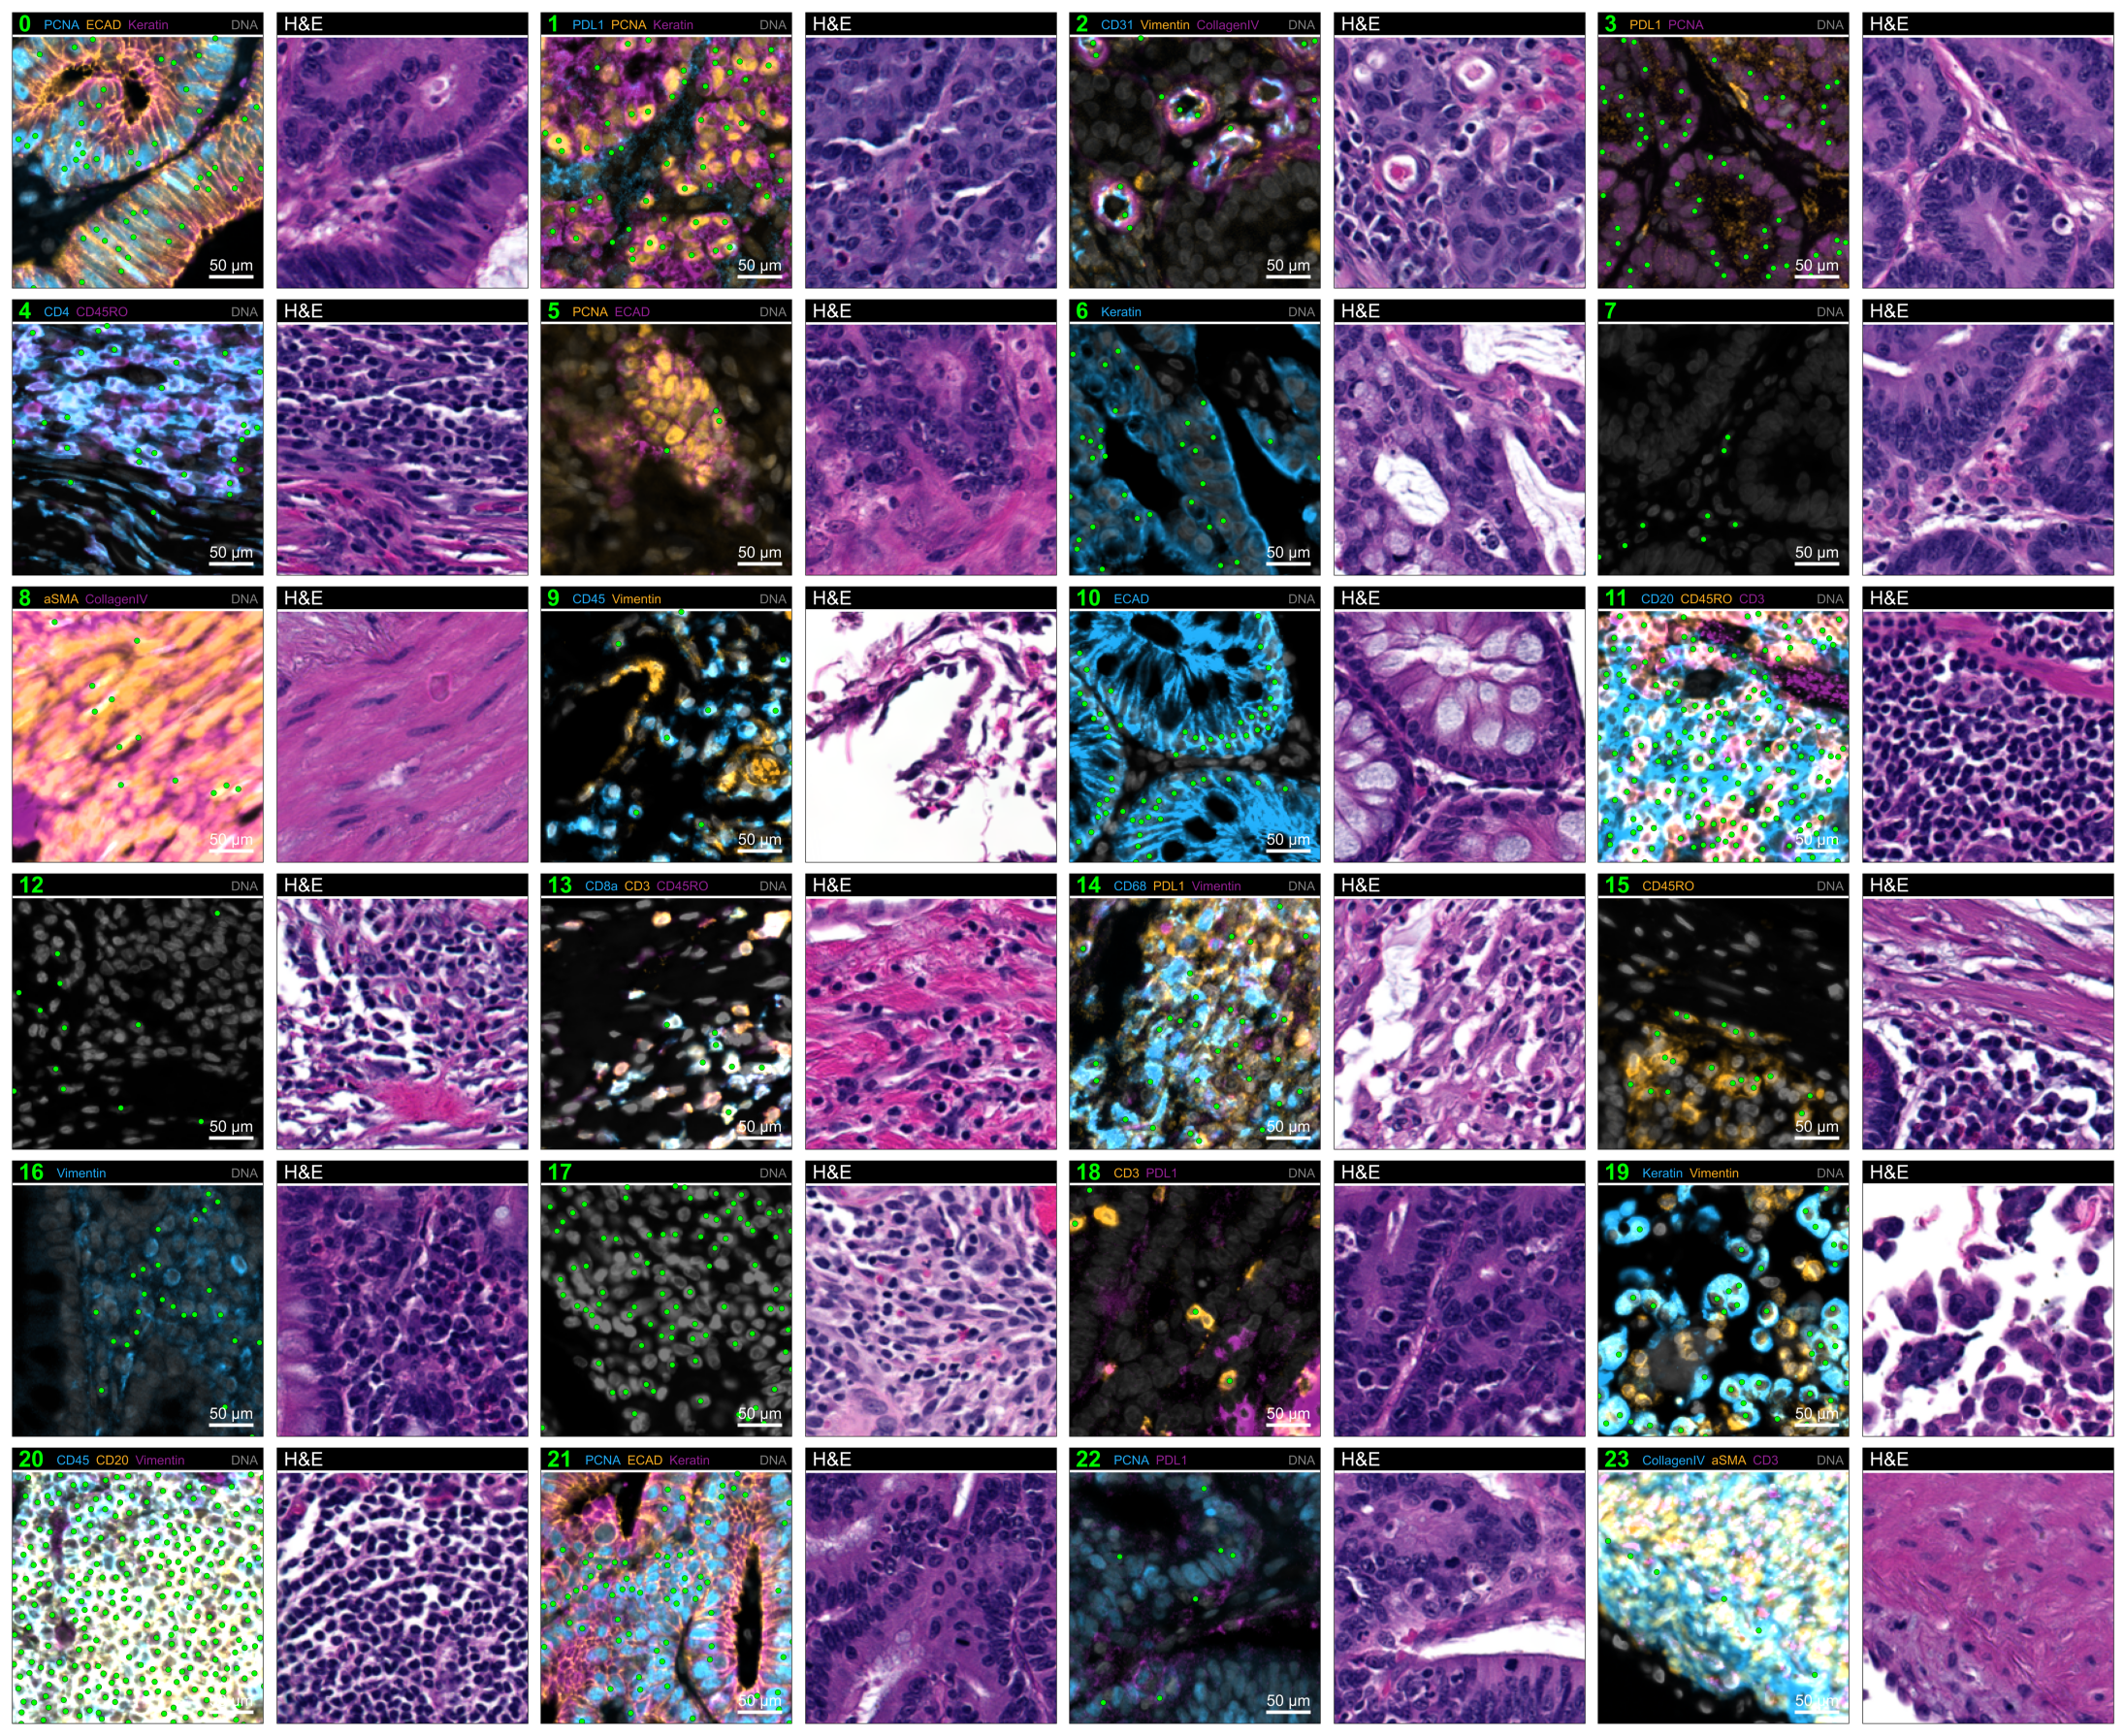

In [7]:
# generate facetgrid showing all cluster images
long_table = pd.DataFrame(columns=['cluster', 'image'])
for e, file in enumerate(os.listdir(out)):
    if not file.startswith('.') and not file.endswith(f'combined.png') and not file.endswith(f'channel_z-scores.pdf'):
        clus_name = file.split('.png')[0]
        img = Image.open(os.path.join(out, file))
        arr = asarray(img)
        long_table.loc[e, 'cluster'] = clus_name
        long_table.loc[e, 'image'] = arr    

# naturally sort longtable by cluster name
long_table.sort_values(by='cluster', key=natsort_keygen(), inplace=True)

g = sns.FacetGrid(
    long_table, col='cluster', col_wrap=8, sharex=False, sharey=False,
    height=3.0, aspect=1.0
)
g.map(
    lambda image, **kwargs: (plt.imshow(image.values[0]), plt.grid(False)), 'image'
)

for ax in g.axes.flatten():
    ax.axis('off')

# g.set_titles(col_template="{col_name}", size=14, fontweight='normal', y=0.81)
for ax in g.axes.flat:
    ax.set_title('')

g.fig.tight_layout()
plt.subplots_adjust(wspace=-0.41, hspace=0.022)  # Adjust the values as needed

plt.savefig(os.path.join(out, 'combined.png'), bbox_inches='tight', dpi=800)
plt.show()